<a href="https://colab.research.google.com/github/daphnecor/Computational_neuroscience/blob/main/Comp_neuro_problemset_week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises week 3 (nonlinear dynamics)

In [1]:
# @title Dependencies
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from pylab import *
import numpy as np
import math
from scipy.integrate import odeint
import seaborn as sns
from sympy import symbols, Eq, solve
import networkx as nx 
import pylab

sns.set_style('white')

 cmap = ['#0c06f7', '#9f2305', '#014600', '#02066f', '#a90308', '#738595']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=cmap) 

## Problem 1. Playing with networks

We have the following system of DE's that represent a regular spiking pyramidal cell:

$$
\dot v = \frac{1}{100} \left( 0.7(v + 60)(v + 40) - u + I \right) \\
\dot u = 0.03 (-2 (v + 60) - u)
$$

which can be written as

$$
\dot v = f(u,v,I) \\
\dot u = g(u,v) \\
$$

with the following reset conditions

```
if v > 35:
  v = -50 
  u += 100
```

### 1a) Implement system in Python

In [2]:
# define differential equations
v_dot = lambda v,u,I: (1/100) * (0.7 * (v + 60) * (v + 40) - u + I)                                
u_dot = lambda v,u: 0.03 * (-2 * (v + 60) - u) 

# specify timesteps
t_range = np.linspace(0,50,1000)

In [3]:
def pyramidal_neuron_system(init, eps, v_dot, u_dot, I, t_range, v_thresh=35, v_reset=-50):
  ''' a regular spiking pyramidal neuron

  Parameters
  ----------
  init: initial values

  eps: step size

  v_dot, u_dot: differential equations

  I: input current (parameter)

  t: range of input values

  v_thresh: spiking threshold

  v_reset: reset potential

  Returns
  -------
  u, v: trajectories of the state variables

  spikes: 0 if no spike, 1 if there is a spike.
  '''
  v = np.zeros(len(t_range))
  u = np.zeros(len(t_range))
  spikes = np.zeros(len(t_range))

  # set initial values 
  v[0] = init[0]
  u[0] = init[1]

  for t in range(0, len(t_range)-1):

    # intermediate step (tilde)
    v_tilde = v[t] + eps * v_dot(v[t], u[t], I)
    u_tilde = u[t] + eps * u_dot(v[t], u[t]) 

    # update v and u
    v[t+1] = v[t] + eps * (1/2) * (v_dot(v[t], u[t], I) + v_dot(v_tilde, u_tilde, I)) 
    u[t+1] = u[t] + eps * (1/2) * (u_dot(v[t], u[t]) + u_dot(v_tilde, u_tilde))

    if v[t+1] > v_thresh: 
      v[t+1] = -50
      u[t+1] += 100
      spikes[t+1] = 1

  return v, u, spikes

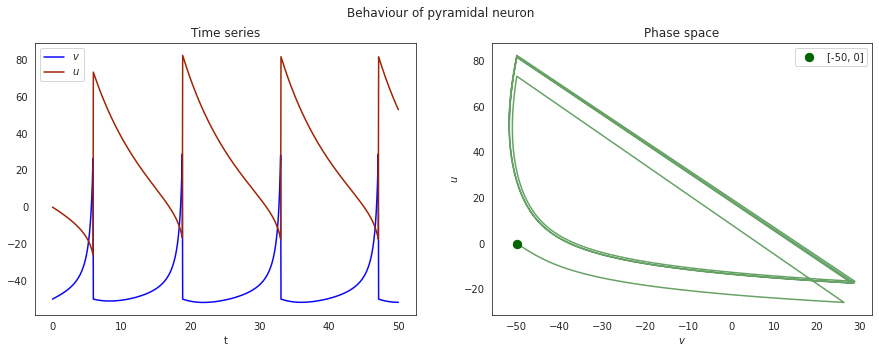

In [4]:
#@title Regular pyramidal spiking neuron
I = 120 #@param {type:"slider", min:0, max:400, step:5}
v0 = -50 #@param {type:"slider", min:-50, max:0, step:5}
u0 = 0 #@param {type:"slider", min:0, max:100, step:5}
eps = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}

v, u, spikes = pyramidal_neuron_system([v0, u0], eps, v_dot, u_dot, I, t_range, v_thresh=35, v_reset=-50)

# figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Behaviour of pyramidal neuron');
ax1.set_title('Time series')
ax1.plot(t_range, v , label =r'$v$');
ax1.plot(t_range, u, label=r'$u$');
ax1.set_xlabel('t')
ax1.legend()

ax2.set_title('Phase space')
ax2.plot(v, u, 'darkgreen', alpha = .6);
ax2.scatter(v0, u0, c='darkgreen', s=70, zorder=2, label=str([v0, u0])) # z order determines order of plotting
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$u$')
ax2.legend();

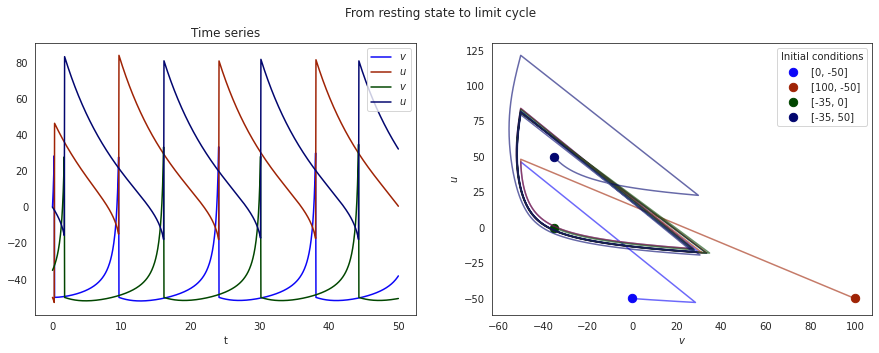

In [5]:
#@title Selected trajectories in phase space 
initial_conds = [[0, -50], [100, -50], [-35, 0], [-35, 50]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('From resting state to limit cycle');
ax1.set_title('Time series')

for i in range(len(initial_conds)):

  v, u, spikes = pyramidal_neuron_system(initial_conds[i], eps, v_dot, u_dot, I, t_range, v_thresh=35, v_reset=-50)
  if i % 2 == 0:
    ax1.plot(t_range, v, label=r'$v$')
    ax1.plot(t_range, u, label=r'$u$')
  ax2.plot(v, u, alpha = .6)
  ax2.scatter(initial_conds[i][0], initial_conds[i][1], s=70, zorder=2, label=str(initial_conds[i])) 

ax1.set_xlabel('t')
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$u$')
ax1.legend()
ax2.legend(title = "Initial conditions");


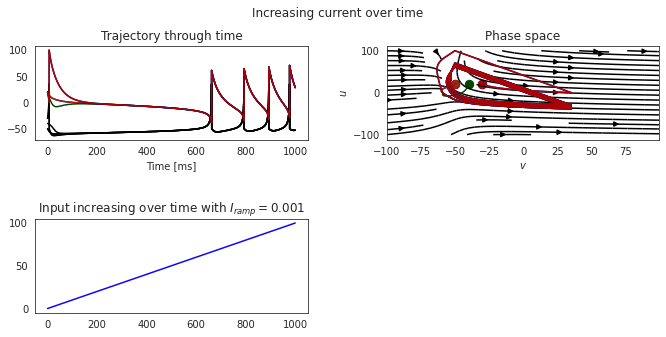

In [6]:
# Neuron with increasing input I
I_ramp = 0.001 #@param {type:"slider", min:-100, max:100, step:0.01}
v0 = -50 #@param {type:"slider", min:-100, max:100, step:1}
u0 = 20 #@param {type:"slider", min:-100, max:100, step:1}

# Parameters
h = .01 # step size
nr_timesteps = 10
neuron_initial = [[v0, u0]] # Initial conditions v, u

def system(t, y, I): # System of ODEs: evaulate at timepoints t
  v, u = y # unpack variables
  v_dot_result = v_dot(v, u, I)
  u_dot_result = u_dot(v, u)
  return np.array([v_dot_result, u_dot_result])

def RK2_reset_ramp(f, neuron, I_ramp, nr_timesteps, h):
  ''' Approximate the solution of y'=f(x,y) with RK method.
  Parameters
  ----------
  f: the differential equation we want to approximate

  neuron: initial values of v0 and u0 at t=0 
  Returns
  --------
  T: timesteps taken
  neuron: approximation of the solution of our system(v, u, I)
  '''
  T = [0] # np.zeros(nr_timesteps/h) # Time vector
  current_I = [0] # 
  for timestep in np.arange(0+h, nr_timesteps/h, h): # Start at t=0+h because we already have the initial values at t=0
    # Record time
    T.append(timestep)
    
    old_v, old_u = neuron[-1] # Get last v and u
    
    # Reset condition
    if old_v > 35:
      new_v = -50
      new_u = old_u + 100
      next_value = [new_v, new_u]
    else: # Otherwise, implement Modified Euler method
      # Take a peak at the values of v and u and their derivatives at the next step
      next_value_wiggle = neuron[-1] + h * system(t = 0, y = [old_v, old_u], I = current_I[-1])
      der_next_value_wiggle = system(t = 0, y = next_value_wiggle, I = current_I[-1])
      next_value = neuron[-1] + 0.5*h * (system(t = 0, y = [old_v, old_u], I = current_I[-1]) + der_next_value_wiggle)

    # Add next value 
    neuron.append(next_value)
        
    # Ramp up input I
    current_I.append(current_I[-1] + I_ramp)

  return [T, neuron, current_I]

# Plot 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,5))

initial_conds = [[[v0, u0]], [[-50, 20]], [[-40, 20]],  [[-30, 20]],  [[-30, 20]]]

for cond in range(len(initial_conds)):
# for cond in range(1):
  # print(initial_conds[cond])
  # print("cond", cond)
  # Run model
  neuron_approx = RK2_reset_ramp(f = system, neuron = initial_conds[cond], I_ramp = I_ramp, nr_timesteps = nr_timesteps, h = h)

  # Get v and u
  v_approx = [entry[0] for entry in neuron_approx[1]]
  u_approx = [entry[1] for entry in neuron_approx[1]]

  # Trajectory through time
  ax1.plot(neuron_approx[0], v_approx, 'k-');
  ax1.plot(neuron_approx[0], u_approx, '-');

  # Trajectory through phase space
  ax2.plot(v_approx, u_approx, color = cmap[cond])
  ax2.scatter(initial_conds[cond][0][0], initial_conds[cond][0][1] , 
              s=70, color=cmap[cond], zorder=2, label=str(initial_conds[cond])) # z order determines order of plotting

fig.suptitle('Increasing current over time');
ax1.set_title('Trajectory through time')
ax1.set_xlabel('Time [ms]')

v_mesh, u_mesh = meshgrid(arange(-100, 100, 0.1), arange(-100, 100, 0.1))       # phase space
ax2.streamplot(v_mesh, u_mesh, v_dot(v_mesh, u_mesh, I), u_dot(v_mesh, u_mesh), density=0.6, color='k')
ax2.set_title('Phase space')
ax2.set_xlabel(r'$v$');
ax2.set_ylabel(r'$u$');

ax3.plot(neuron_approx[0], neuron_approx[2]) # Plot input increase over time
ax3.set_title("Input increasing over time with " + r"$I_{ramp} = $" + str(I_ramp))
fig.tight_layout(pad=3.0) # Add spacing between subplots
fig.delaxes(ax4); # Delete empty plot

### 1b) Pyramidal neuron model properties

We answer the questions separately below:

---
> for what value of I does the neuron spike
---

Parameterising the system with $u_0 = 0$ and $v_0 = -50$ (at resting potential) and setting the step size $\epsilon = 0.2$ we find that the neuron spikes when $I \approx 60$. By increasing the current the firing frequency increases. Slowly increasing the current $I$ shows that the neuron requires a certain amount of current $I$ before it spikes ($I \approx 60$); stimulating it below this threshold current barely has any effect on its voltage.

---
> describe the bifurcation at the onset of spiking
---

If given sufficient current $I$, the neuron bifurcates from its resting state ($-50 mV$) to spiking. This regular spiking behaviour corresponds to a limit cycle in the phase space. The neuron is bistable: it is quiescent for low inputs $I$, yet can enter a stable limit cycle for input values $I > 60$. The neuron seems to be an integrator as it accumulates current and does not show any subthreshold oscillations (in which the voltage oscillates close to the threshold without spiking) as a resonator would. 

---
> how does the firing rate vary with $I$
---

The firing frequency increases linearly with the increase of input current $I$. In contrary to the AdEx model, which is also a 2D neuronal model with auxiliary variable $\dot w$, $u$ does not increase the time interval between spikes.





### 1c) A network of coupled neurons

In [7]:
def pyramidal_neuron(vt, ut, eps, v_dot, u_dot, I, v_thresh=35, v_reset=-50):
  ''' a regular spiking pyramidal neuron for one time step (easy to use for network of coupled neurons)
  '''
  spike = 0

  # intermediate step (tilde)
  v_tilde = vt + eps * v_dot(vt, ut, I) 

  u_tilde = ut + eps * u_dot(vt, ut) 

  # update v and u
  v_next = vt + eps * (1/2) * (v_dot(vt, ut, I) + v_dot(v_tilde, u_tilde, I)) 

  u_next = ut + eps * (1/2) * (u_dot(vt, ut) + u_dot(v_tilde, u_tilde))

  if v_next > v_thresh: 
    v_next = v_reset
    u_next += 100
    spike = 1

  return v_next, u_next, spike

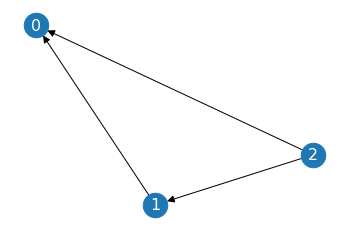

In [8]:
# Parameters
scalar = 5000 #@param {type:"slider", min:-10000, max:10000, step:1}
n = 3 # number of neurons
eps = 0.5 # step size
timesteps = np.arange(0, 40, 1)
v_thresh = 35

# general connection matrix
send_M = np.array([
    [0,0,0],
    [1,0,0],
    [1,1,0]]) # To which neuron it sends input

receiv_M = np.array([
    [0,1,1],
    [0,0,1],
    [0,0,0]]) # To which neuron it sends input

# construct network from adj matrix to visualise connectivity
G = nx.from_numpy_matrix(send_M, create_using=nx.DiGraph)
nx.draw_networkx(G,pos=nx.spring_layout(G), 
                 arrows=True, node_size=600, 
                 cmap=plt.get_cmap('viridis'), 
                 font_color='white', font_size=16, arrowsize=15)
pylab.axis('off');

In [22]:
# create evolution arrays
v1 = np.zeros((len(timesteps), 1))
v2 = np.zeros((len(timesteps), 1))
v3 = np.zeros((len(timesteps), 1))

u1 = np.zeros((len(timesteps), 1))
u2 = np.zeros((len(timesteps), 1))
u3 = np.zeros((len(timesteps), 1))

current = np.zeros((len(timesteps), 3))
spiking_behaviour = []

for t in range(0, len(timesteps)-1):

  if t == 0: # initialise at first time step
    v1[0], u1[0]  = -30, 0
    v2[0], u2[0]  = -40, 0
    v3[0], u3[0]  = -50, 0
    binary_arr = np.array([0, 0, 0])
    spiking_behaviour.append([0, 0, 0])

  I = np.array([40, 40, 800]) # input currents for neurons

  # update current based on whether some neurons spiked or not
  I = I + receiv_M @ (scalar * binary_arr)
  
  v1[t+1], u1[t+1], spike1 = pyramidal_neuron(v1[t], u1[t], eps, v_dot, u_dot, I[0], v_thresh=v_thresh, v_reset=-50)
  v2[t+1], u2[t+1], spike2 = pyramidal_neuron(v2[t], u2[t], eps, v_dot, u_dot, I[1], v_thresh=v_thresh, v_reset=-50)
  v3[t+1], u3[t+1], spike3 = pyramidal_neuron(v3[t], u3[t], eps, v_dot, u_dot, I[2], v_thresh=v_thresh, v_reset=-50)
  current[t+1, :] = I

  # check if the neurons spiked and append
  binary_arr = np.array([spike1, spike2, spike3])
  spiking_behaviour.append([spike1, spike2, spike3])

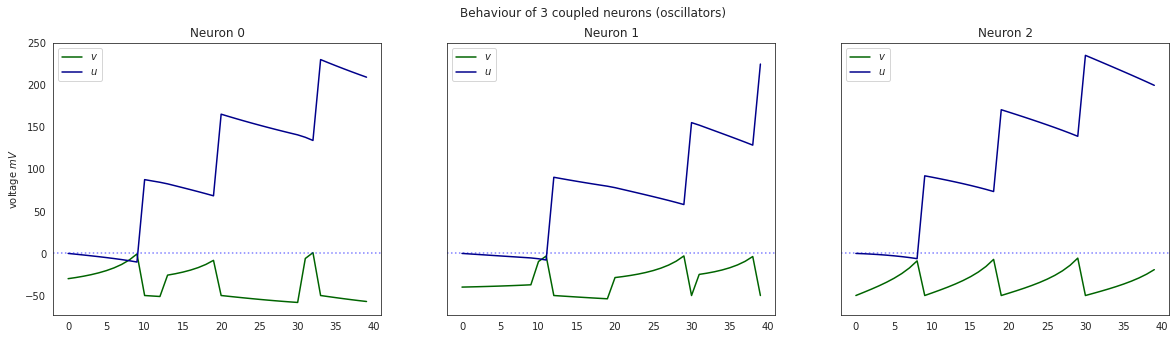

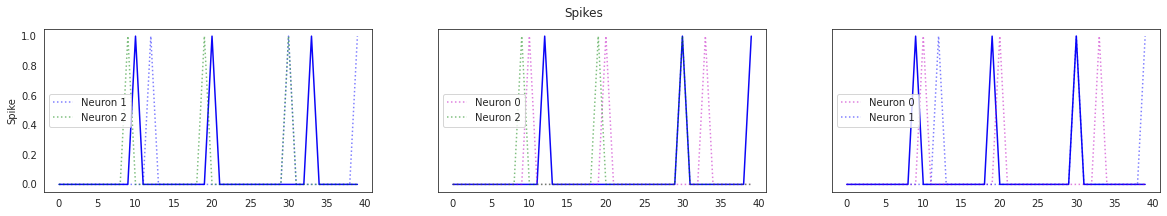

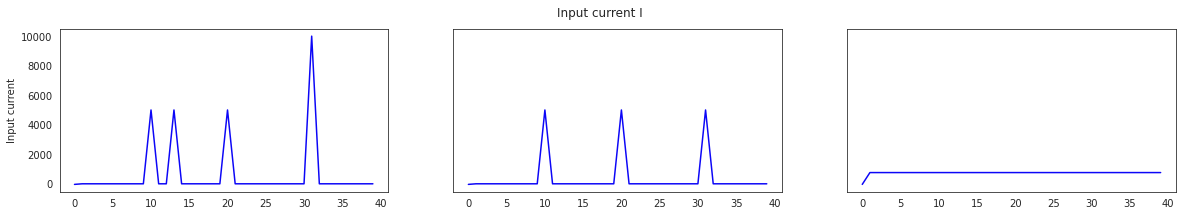

In [23]:
#@title Coupled oscillators
# figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5), sharey= True)

fig.suptitle('Behaviour of 3 coupled neurons (oscillators)');
ax1.set_title('Neuron 0')
ax1.plot(timesteps, v1,'darkgreen', label =r'$v$');
ax1.plot(timesteps, u1, 'darkblue', label=r'$u$');
ax1.axhline(y = v_thresh, color = 'b', linestyle = 'dotted', alpha = .5)
ax1.set_ylabel('voltage $mV$')
ax1.legend()

ax2.set_title('Neuron 1')
ax2.plot(timesteps, v2,'darkgreen', label =r'$v$');
ax2.axhline(y = v_thresh, color = 'b', linestyle = 'dotted', alpha = .5)
ax2.plot(timesteps, u2, 'darkblue', label=r'$u$');
ax2.legend();

ax3.set_title('Neuron 2')
ax3.plot(timesteps, v3,'darkgreen', label =r'$v$');
ax3.axhline(y = v_thresh, color = 'b', linestyle = 'dotted', alpha = .5)
ax3.plot(timesteps, u3, 'darkblue', label=r'$u$');
ax3.legend();

# plot spiking_behaviour
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3), sharey = True)
fig.suptitle("Spikes");
ax1.plot(timesteps, [entry[0] for entry in spiking_behaviour])
ax1.plot(timesteps, [entry[1] for entry in spiking_behaviour], alpha = .5, color = 'b', linestyle = 'dotted', label = "Neuron 1")
ax1.plot(timesteps, [entry[2] for entry in spiking_behaviour], alpha = .5, color = 'g', linestyle = 'dotted', label = "Neuron 2")
# ax1.set_ylim([0,200])
ax1.set_ylabel('Spike')
ax1.legend()

ax2.plot(timesteps, [entry[1] for entry in spiking_behaviour])
ax2.plot(timesteps, [entry[0] for entry in spiking_behaviour], alpha = .5, color = 'm', linestyle = 'dotted', label = "Neuron 0")
ax2.plot(timesteps, [entry[2] for entry in spiking_behaviour], alpha = .5, color = 'g', linestyle = 'dotted', label = "Neuron 2")
# ax2.set_ylim([0,200])
ax2.legend()

ax3.plot(timesteps, [entry[2] for entry in spiking_behaviour]);
ax3.plot(timesteps, [entry[0] for entry in spiking_behaviour], alpha = .5, color = 'm', linestyle = 'dotted', label = "Neuron 0")
ax3.plot(timesteps, [entry[1] for entry in spiking_behaviour], alpha = .5, color = 'b', linestyle = 'dotted', label = "Neuron 1")
# ax3.set_ylim([0,200]);
ax3.legend()

# plot received current
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3), sharey = True)
fig.suptitle("Input current " + r"I");
ax1.plot(timesteps, current[:, 0])
# ax1.set_ylim([0,200])
ax1.set_ylabel('Input current')

ax2.plot(timesteps, current[:, 1])
# ax2.set_ylim([0,200])

ax3.plot(timesteps, current[:, 2]);
# ax3.set_ylim([0,200]);

Here we have created a model where neuron 2 sends excitatory inputs to neuron 0 and 1 and neuron 1 only sends - but does not receive - excitatory currents from neuron 0. Because neuron 2 does not receive any inputs from the other two neurons, its spiking behaviour will not be influenced by their spike times, yet conversely, neuron 0's and 1's spiking behaviour will be influenced by that of neuron 2. Indeed, we see that when the other two neurons spike, this has no influence on neuron 2's voltage (second row, third plot) as there is no additional input current (third row, third plot). Similarly, neuron 0's spiking behaviour has no influence on the voltage of neuron 1 (second row, second plot). Finally, neuron 0 is influenced both by neuron 1 and neuron 2 (second row, first plot). 

We can also study this connectivity with inhibitory inputs by changing the scalar to a negative value (e.g. $I = -5000$). Try for yourself!

## Problem 2. Phase resetting curves

The Phase resetting curve (PRC) is a change in phase
\begin{align}
  \Delta (\phi) = \phi' - \phi
\end{align}
due to a pulse at phase $\phi$. It can be determined by applying a set of pulses at different times or by [several analytical methods](http://www.scholarpedia.org/article/Isochron).



### a) 

Calculate the PRC of the leaky-inegrate-and-fire model neuron 
\begin{align}
  \tau \dot V = I - V
\end{align}
with $I>0$.
The membrane potential $V$ is reset when it exceeds a threshold
```
if V > 1:
  V = 0 
```

> Step 1. associate a phase with each value of $V$

Solving the ODE yields

\begin{align}
  v(t) = v_0 e^{-\frac{t}{\tau}} + I - e^{-\frac{t}{\tau}}
\end{align}

where $v(t) = v_0$. The natural period of the neuron $T$ is then

\begin{align}
  T = -\tau \ln \left( 1 - \frac{1}{I} \right) \qquad , v_0 = 0
\end{align}

If we associate the phase of the neuron $\phi \in [0,1]$ and time $0 \leq t$ by

\begin{align}
  
\end{align}

```
By Daphne Cornelisse & Kyra Evers
November 27, 2020
```